In [1]:
!pip install tensorflow scikit-learn pandas matplotlib imbalanced-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy import stats

In [3]:
DATA_PATH = "letter-recognition.data"
HEADERS = [
    "lettr",
    "x-box",
    "y-box",
    "width",
    "high",
    "onpix",
    "x-bar",
    "y-bar",
    "x2bar",
    "y2bar",
    "xybar",
    "x2ybr",
    "xy2br",
    "x-ege",
    "xegvy",
    "y-ege",
    "yegvx",
]

In [4]:
data = pd.read_csv(DATA_PATH, header=None, names=HEADERS)

In [5]:
data.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


# Preprocessing

In [6]:
data.shape

(20000, 17)

<BarContainer object of 26 artists>

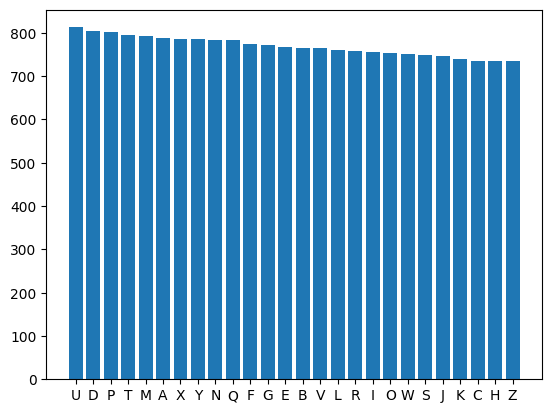

In [7]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [8]:
# remove duplicates
data.drop_duplicates(inplace=True)

In [9]:
data.shape

(18668, 17)

<BarContainer object of 26 artists>

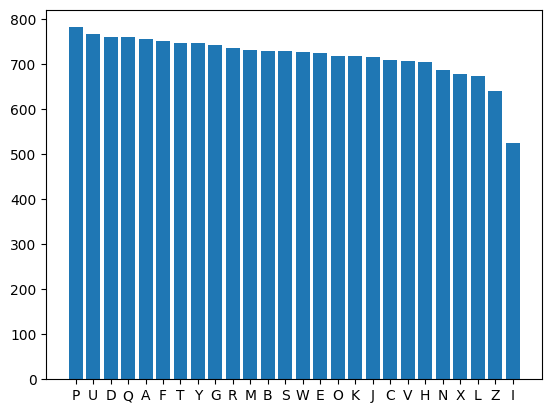

In [10]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [11]:
# remove outliers
z_scores = stats.zscore(data[HEADERS[1:]])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

In [12]:
data.shape

(17257, 17)

<BarContainer object of 26 artists>

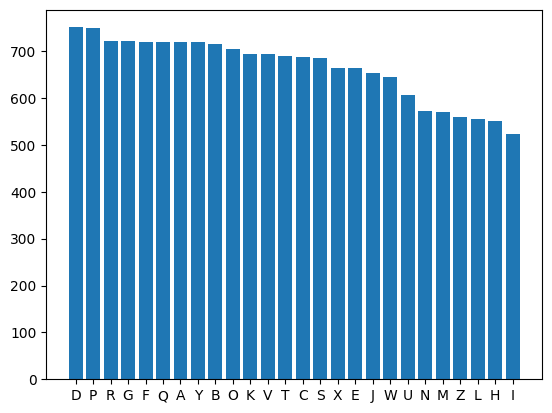

In [13]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [14]:
# Under sampling
rus = RandomUnderSampler(random_state=42)
under_sample, under_sample_labels = rus.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [15]:
under_sample.shape

(13598, 16)

<BarContainer object of 26 artists>

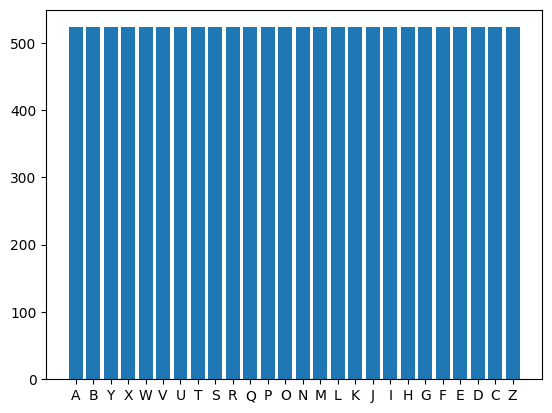

In [16]:
plt.bar(
    pd.Series(under_sample_labels).value_counts().index,
    pd.Series(under_sample_labels).value_counts().values,
)

In [17]:
# Over sampling
ros = RandomOverSampler(random_state=42)
over_sample, over_sample_labels = ros.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [18]:
over_sample.shape

(19526, 16)

<BarContainer object of 26 artists>

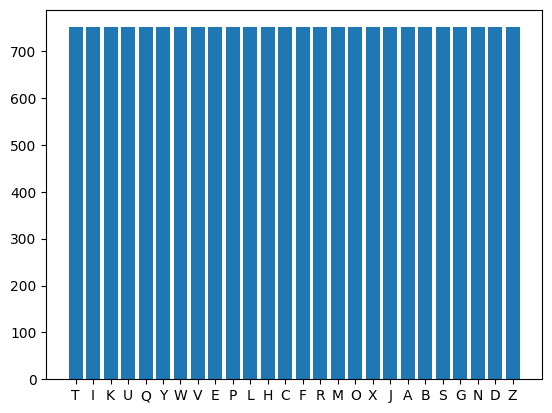

In [19]:
plt.bar(
    pd.Series(over_sample_labels).value_counts().index,
    pd.Series(over_sample_labels).value_counts().values,
)

In [20]:
# SMOTE
smote = SMOTE(random_state=42)
smote_sample, smote_sample_labels = smote.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [21]:
smote_sample.shape

(19526, 16)

<BarContainer object of 26 artists>

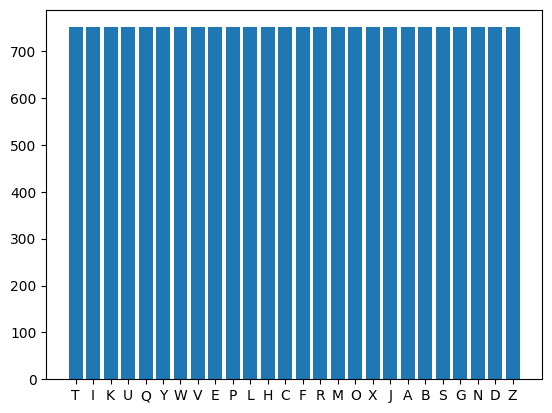

In [22]:
plt.bar(
    pd.Series(smote_sample_labels).value_counts().index,
    pd.Series(smote_sample_labels).value_counts().values,
)

In [23]:
data["lettr"] = data["lettr"].apply(lambda x: ord(x) - 65)
smote_sample_labels = smote_sample_labels.apply(lambda x: ord(x) - 65)
over_sample_labels = over_sample_labels.apply(lambda x: ord(x) - 65)
under_sample_labels = under_sample_labels.apply(lambda x: ord(x) - 65)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    data[HEADERS[1:]], data[HEADERS[0]], test_size=0.20, random_state=42
)
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(
    smote_sample, smote_sample_labels, test_size=0.20, random_state=42
)
x_train_under, x_test_under, y_train_under, y_test_under = train_test_split(
    under_sample, under_sample_labels, test_size=0.20, random_state=42
)
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(
    over_sample, over_sample_labels, test_size=0.20, random_state=42
)
x_train_over.shape, x_test_over.shape, y_train_over.shape, y_test_over.shape

((15620, 16), (3906, 16), (15620,), (3906,))

In [25]:
x_train = tf.keras.utils.normalize(x_train.values, axis=1)
x_test = tf.keras.utils.normalize(x_test.values, axis=1)
x_train_smote = tf.keras.utils.normalize(x_train_smote, axis=1)
x_test_smote = tf.keras.utils.normalize(x_test_smote, axis=1)
x_train_under = tf.keras.utils.normalize(x_train_under, axis=1)
x_test_under = tf.keras.utils.normalize(x_test_under, axis=1)
x_train_over = tf.keras.utils.normalize(x_train_over, axis=1)
x_test_over = tf.keras.utils.normalize(x_test_over, axis=1)

In [26]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(x_train, y_train, epochs=40)

Epoch 1/40
432/432 [==============================] - 1s 884us/step - loss: 2.2067 - accuracy: 0.3996
Epoch 2/40
432/432 [==============================] - 0s 847us/step - loss: 1.3081 - accuracy: 0.6327
Epoch 3/40
432/432 [==============================] - 0s 843us/step - loss: 1.1216 - accuracy: 0.6850
Epoch 4/40
432/432 [==============================] - 0s 852us/step - loss: 1.0233 - accuracy: 0.7102
Epoch 5/40
432/432 [==============================] - 0s 862us/step - loss: 0.9534 - accuracy: 0.7305
Epoch 6/40
432/432 [==============================] - 0s 900us/step - loss: 0.8944 - accuracy: 0.7421
Epoch 7/40
432/432 [==============================] - 0s 996us/step - loss: 0.8439 - accuracy: 0.7611
Epoch 8/40
432/432 [==============================] - 0s 1ms/step - loss: 0.7918 - accuracy: 0.7698
Epoch 9/40
432/432 [==============================] - 0s 844us/step - loss: 0.7547 - accuracy: 0.7825
Epoch 10/40
432/432 [==============================] - 0s 854us/step - loss: 0.7129 

In [27]:
model.evaluate(x_test, y_test)

108/108 [==============================] - 0s 765us/step - loss: 0.2918 - accuracy: 0.9085


[0.29175105690956116, 0.9084588885307312]

In [28]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(x_train_over, y_train_over, epochs=40)

Epoch 1/40
489/489 [==============================] - 1s 864us/step - loss: 2.1525 - accuracy: 0.4203
Epoch 2/40
489/489 [==============================] - 0s 830us/step - loss: 1.3151 - accuracy: 0.6266
Epoch 3/40
489/489 [==============================] - 0s 876us/step - loss: 1.1219 - accuracy: 0.6809
Epoch 4/40
489/489 [==============================] - 0s 842us/step - loss: 1.0114 - accuracy: 0.7139
Epoch 5/40
489/489 [==============================] - 0s 844us/step - loss: 0.9282 - accuracy: 0.7385
Epoch 6/40
489/489 [==============================] - 0s 853us/step - loss: 0.8685 - accuracy: 0.7500
Epoch 7/40
489/489 [==============================] - 0s 836us/step - loss: 0.8046 - accuracy: 0.7701
Epoch 8/40
489/489 [==============================] - 0s 830us/step - loss: 0.7516 - accuracy: 0.7830
Epoch 9/40
489/489 [==============================] - 0s 858us/step - loss: 0.7052 - accuracy: 0.7964
Epoch 10/40
489/489 [==============================] - 0s 852us/step - loss: 0.662

In [29]:
model.evaluate(x_test_over, y_test_over)

123/123 [==============================] - 0s 753us/step - loss: 0.2667 - accuracy: 0.9101


[0.2667314112186432, 0.9101382493972778]

In [30]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(x_train_under, y_train_under, epochs=40)

Epoch 1/40
340/340 [==============================] - 1s 854us/step - loss: 2.3819 - accuracy: 0.3597
Epoch 2/40
340/340 [==============================] - 0s 838us/step - loss: 1.4943 - accuracy: 0.5757
Epoch 3/40
340/340 [==============================] - 0s 827us/step - loss: 1.2582 - accuracy: 0.6446
Epoch 4/40
340/340 [==============================] - 0s 829us/step - loss: 1.1298 - accuracy: 0.6815
Epoch 5/40
340/340 [==============================] - 0s 830us/step - loss: 1.0429 - accuracy: 0.7071
Epoch 6/40
340/340 [==============================] - 0s 829us/step - loss: 0.9724 - accuracy: 0.7234
Epoch 7/40
340/340 [==============================] - 0s 835us/step - loss: 0.9172 - accuracy: 0.7376
Epoch 8/40
340/340 [==============================] - 0s 1ms/step - loss: 0.8712 - accuracy: 0.7492
Epoch 9/40
340/340 [==============================] - 0s 1ms/step - loss: 0.8205 - accuracy: 0.7632
Epoch 10/40
340/340 [==============================] - 0s 1ms/step - loss: 0.7776 - ac

In [31]:
model.evaluate(x_test_under, y_test_under)

85/85 [==============================] - 0s 791us/step - loss: 0.2941 - accuracy: 0.9121


[0.2940536141395569, 0.9121323823928833]

In [32]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [33]:
y_pred = knn.predict(x_test)

In [34]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       129
           1       0.85      0.98      0.91       135
           2       0.98      0.98      0.98       130
           3       0.87      0.95      0.91       162
           4       0.88      0.92      0.90       145
           5       0.94      0.94      0.94       157
           6       0.93      0.92      0.92       135
           7       0.80      0.83      0.82        99
           8       0.89      0.98      0.93       102
           9       0.97      0.91      0.94       137
          10       0.93      0.91      0.92       138
          11       1.00      0.96      0.98       118
          12       0.99      0.97      0.98       124
          13       0.97      0.94      0.96       118
          14       0.93      0.92      0.93       139
          15       0.97      0.95      0.96       149
          16       0.94      0.93      0.93       142
          17       0.95    

In [35]:
param_grid = {"n_neighbors": [3, 5, 7, 9, 11, 13, 15]}
grid = GridSearchCV(knn, param_grid, n_jobs=-1)
grid.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15]})

In [36]:
print(grid.best_params_)

{'n_neighbors': 3}
